In [1]:
cd /home/ubuntu/FedEM/

/home/ubuntu/FedEM


In [2]:
# Import General Libraries
import os
import argparse
import torch
import copy
import pickle
import random
import numpy as np
import pandas as pd

# Import FedEM based Libraries
from utils.utils import *
from utils.constants import *
from utils.args import *
from torch.utils.tensorboard import SummaryWriter
from run_experiment import *
from models import *

# Import Transfer Attack
from transfer_attacks.Personalized_NN import *
from transfer_attacks.Params import *
from transfer_attacks.Transferer import *
from transfer_attacks.Args import *

from transfer_attacks.TA_utils import *
from transfer_attacks.Boundary_Transferer import *

In [19]:
# Manually set argument parameters
args_ = Args()
args_.experiment = "cifar10"
args_.method = "FedEM"
args_.decentralized = False
args_.sampling_rate = 1.0
args_.input_dimension = None
args_.output_dimension = None
args_.n_learners= 3
args_.n_rounds = 10
args_.bz = 128
args_.local_steps = 1
args_.lr_lambda = 0
args_.lr =0.03
args_.lr_scheduler = 'multi_step'
args_.log_freq = 10
args_.device = 'cuda'
args_.optimizer = 'sgd'
args_.mu = 0
args_.communication_probability = 0.1
args_.q = 1
args_.locally_tune_clients = False
args_.seed = 1234
args_.verbose = 1
args_.save_path = 'weights/cifar/22_01_09_fedavg_n80_benign/'
args_.validation = False
args_.num_user = 40

# Generate the dummy values here
aggregator, clients = dummy_aggregator(args_, num_user=40)

==> Clients initialization..
===> Building data iterators..


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 361.10it/s]


===> Initializing clients..


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:35<00:00,  2.28it/s]


==> Test Clients initialization..
===> Building data iterators..


0it [00:00, ?it/s]


===> Initializing clients..


0it [00:00, ?it/s]


++++++++++++++++++++++++++++++
Global..
Train Loss: 2.292 | Train Acc: 12.221% |Test Loss: 2.290 | Test Acc: 12.547% |
++++++++++++++++++++++++++++++++++++++++++++++++++
################################################################################


In [20]:
# Combine Validation Data across all clients as test
data_x = []
data_y = []

for i in range(len(clients)):
    daniloader = clients[i].val_iterator
    for (x,y,idx) in daniloader.dataset:
        data_x.append(x)
        data_y.append(y)

data_x = torch.stack(data_x)
data_y = torch.stack(data_y)

# Create dataloader from validation dataset that allows for diverse batch size
dataloader = Custom_Dataloader(data_x, data_y)

In [26]:
# Import Model Weights
setting = 'FedEM'

if setting == 'FedEM':
    nL = 3
else:
    nL = 1

adv_mode = True   

num_models = 40

np.set_printoptions(formatter={'float': lambda x: "{0:0.2f}".format(x)})

if setting == 'local':

    if adv_mode:
        args_.save_path ='weights/cifar100/feddef_l2/local/'
        aggregator.load_state(args_.save_path)

        model_weights = []
        weights = np.load('weights/cifar100/feddef_l2/local/train_client_weights.npy')
    else:
        args_.save_path ='weights/cifar100/first_test/local/'
        aggregator.load_state(args_.save_path)

        model_weights = []
        weights = np.load('weights/cifar100/first_test/local/train_client_weights.npy')
    
    for i in range(num_models):
        model_weights += [weights[i]]

    # Generate the weights to test on as linear combinations of the model_weights
    models_test = []

    for i in range(num_models):
        new_model = copy.deepcopy(aggregator.clients[i].learners_ensemble.learners[0].model)
        new_model.eval()
        models_test += [new_model]

elif setting == 'FedAvg':
    
    
    if adv_mode:
        args_.save_path = 'weights/neurips/cifar/krum/just_attack/fedavg_adv/'
    else:
        args_.save_path = 'weights/neurips/cifar/krum/just_attack/fedavg/'
    aggregator.load_state(args_.save_path)
    
    # This is where the models are stored -- one for each mixture --> learner.model for nn
    hypotheses = aggregator.global_learners_ensemble.learners

    # obtain the state dict for each of the weights 
    weights_h = []

    for h in hypotheses:
        weights_h += [h.model.state_dict()]
    
    if adv_mode:
        weights = np.load('weights/neurips/cifar/krum/just_attack/fedavg_adv/train_client_weights.npy')
    else:
        weights = np.load('weights/neurips/cifar/krum/just_attack/fedavg/train_client_weights.npy')
    
    # Set model weights
    model_weights = []

    for i in range(num_models):
        model_weights += [weights[i]]

    # Generate the weights to test on as linear combinations of the model_weights
    models_test = []

    for (w0) in model_weights:
        # first make the model with empty weights
        new_model = copy.deepcopy(hypotheses[0].model)
        new_model.eval()
        new_weight_dict = copy.deepcopy(weights_h[0])
        for key in weights_h[0]:
            new_weight_dict[key] = w0[0]*weights_h[0][key] 
        new_model.load_state_dict(new_weight_dict)
        models_test += [new_model]

elif setting == 'FedEM':
    
    if adv_mode:
        args_.save_path = 'weights/neurips/cifar/krum/just_attack/fedem_adv/'
    else:
        args_.save_path = 'weights/neurips/cifar/krum/just_attack/fedem/'
    aggregator.load_state(args_.save_path)
    
    # This is where the models are stored -- one for each mixture --> learner.model for nn
    hypotheses = aggregator.global_learners_ensemble.learners

    # obtain the state dict for each of the weights 
    weights_h = []

    for h in hypotheses:
        weights_h += [h.model.state_dict()]

    if adv_mode:
        weights = np.load('weights/neurips/cifar/krum/just_attack/fedem_adv/train_client_weights.npy')
    else:
        weights = np.load('weights/neurips/cifar/krum/just_attack/fedem/train_client_weights.npy')

    # Set model weights
    model_weights = []

    for i in range(num_models):
        model_weights += [weights[i]]


    # Generate the weights to test on as linear combinations of the model_weights
    models_test = []

    for (w0,w1,w2) in model_weights:
        # first make the model with empty weights
        new_model = copy.deepcopy(hypotheses[0].model)
        new_model.eval()
        new_weight_dict = copy.deepcopy(weights_h[0])
        for key in weights_h[0]:
            new_weight_dict[key] = w0*weights_h[0][key] + w1*weights_h[1][key] + w2*weights_h[2][key]
        new_model.load_state_dict(new_weight_dict)
        models_test += [new_model]

In [27]:
# Here we will make a dictionary that will hold results
logs_adv = []

for i in range(num_models):
    adv_dict = {}
    adv_dict['orig_acc_transfers'] = None
    adv_dict['orig_similarities'] = None
    adv_dict['adv_acc_transfers'] = None
    adv_dict['adv_similarities_target'] = None
    adv_dict['adv_similarities_untarget'] = None
    adv_dict['adv_target'] = None
    adv_dict['adv_miss'] = None
    adv_dict['metric_alignment'] = None
    adv_dict['ib_distance_legit'] = None
    adv_dict['ib_distance_adv'] = None

    logs_adv += [adv_dict]
    

In [28]:
# Perform transfer attack from one client to another and record stats

# Run Measurements for both targetted and untargeted analysis
new_num_models = len(models_test)
victim_idxs = range(new_num_models)
custom_batch_size = 500
eps = 4.5


# Record number of batch sizes
batch_size_recs = np.ones([new_num_models,new_num_models])

for adv_idx in victim_idxs:
    print("\t Adv idx:", adv_idx)
    
    dataloader = load_client_data(clients = clients, c_id = adv_idx, mode = 'test') # or test/train
    
    batch_size = min(custom_batch_size, dataloader.y_data.shape[0])
    batch_size_recs[adv_idx,:] *= batch_size
    
    t1 = Transferer(models_list=models_test, dataloader=dataloader)
    t1.generate_victims(victim_idxs)
    
    # Perform Attacks Targeted
    t1.atk_params = PGD_Params()
    t1.atk_params.set_params(batch_size=batch_size, iteration = 10,
                   target = 3, x_val_min = torch.min(data_x), x_val_max = torch.max(data_x),
                   step_size = 0.01, step_norm = "inf", eps = eps, eps_norm = 2)
    
    
    
    t1.generate_advNN(adv_idx)
    t1.generate_xadv(atk_type = "pgd")
    t1.send_to_victims(victim_idxs)

    # Log Performance
    logs_adv[adv_idx]['orig_acc_transfers'] = copy.deepcopy(t1.orig_acc_transfers)
    logs_adv[adv_idx]['orig_similarities'] = copy.deepcopy(t1.orig_similarities)
    logs_adv[adv_idx]['adv_acc_transfers'] = copy.deepcopy(t1.adv_acc_transfers)
    logs_adv[adv_idx]['adv_similarities_target'] = copy.deepcopy(t1.adv_similarities)        
    logs_adv[adv_idx]['adv_target'] = copy.deepcopy(t1.adv_target_hit)

    # Miss attack Untargeted
    t1.atk_params.set_params(batch_size=batch_size, iteration = 10,
                   target = -1, x_val_min = torch.min(data_x), x_val_max = torch.max(data_x),
                   step_size = 0.01, step_norm = "inf", eps = eps, eps_norm = 2)
    t1.generate_xadv(atk_type = "pgd")
    t1.send_to_victims(victim_idxs)
    logs_adv[adv_idx]['adv_miss'] = copy.deepcopy(t1.adv_acc_transfers)
    logs_adv[adv_idx]['adv_similarities_untarget'] = copy.deepcopy(t1.adv_similarities)

	 Adv idx: 0
	 Adv idx: 1
	 Adv idx: 2
	 Adv idx: 3
	 Adv idx: 4
	 Adv idx: 5
	 Adv idx: 6
	 Adv idx: 7
	 Adv idx: 8
	 Adv idx: 9
	 Adv idx: 10
	 Adv idx: 11
	 Adv idx: 12
	 Adv idx: 13
	 Adv idx: 14
	 Adv idx: 15
	 Adv idx: 16
	 Adv idx: 17
	 Adv idx: 18
	 Adv idx: 19
	 Adv idx: 20
	 Adv idx: 21
	 Adv idx: 22
	 Adv idx: 23
	 Adv idx: 24
	 Adv idx: 25
	 Adv idx: 26
	 Adv idx: 27
	 Adv idx: 28
	 Adv idx: 29
	 Adv idx: 30
	 Adv idx: 31
	 Adv idx: 32
	 Adv idx: 33
	 Adv idx: 34
	 Adv idx: 35
	 Adv idx: 36
	 Adv idx: 37
	 Adv idx: 38
	 Adv idx: 39


In [29]:
metrics = ['orig_acc_transfers','orig_similarities','adv_acc_transfers','adv_similarities_target',
           'adv_similarities_untarget','adv_target','adv_miss'] #,'metric_alignment']

orig_acc = np.zeros([new_num_models, new_num_models]) 
orig_sim = np.zeros([new_num_models, new_num_models]) 
adv_acc = np.zeros([new_num_models, new_num_models]) 
adv_sim_target = np.zeros([new_num_models, new_num_models]) 
adv_sim_untarget = np.zeros([new_num_models, new_num_models]) 
adv_target = np.zeros([new_num_models, new_num_models])
adv_miss = np.zeros([new_num_models, new_num_models]) 

for adv_idx in range(num_models):
    for victim in range(num_models):
        orig_acc[adv_idx,victim] = logs_adv[victim_idxs[adv_idx]][metrics[0]][victim_idxs[victim]].data.tolist()
        orig_sim[adv_idx,victim] = logs_adv[victim_idxs[adv_idx]][metrics[1]][victim_idxs[victim]].data.tolist()
        adv_acc[adv_idx,victim] = logs_adv[victim_idxs[adv_idx]][metrics[2]][victim_idxs[victim]].data.tolist()
        adv_sim_target[adv_idx,victim] = logs_adv[victim_idxs[adv_idx]][metrics[3]][victim_idxs[victim]].data.tolist()
        adv_sim_untarget[adv_idx,victim] = logs_adv[victim_idxs[adv_idx]][metrics[4]][victim_idxs[victim]].data.tolist()
        adv_target[adv_idx,victim] = logs_adv[victim_idxs[adv_idx]][metrics[5]][victim_idxs[victim]].data.tolist()
        adv_miss[adv_idx,victim] = logs_adv[victim_idxs[adv_idx]][metrics[6]][victim_idxs[victim]].data.tolist()

In [30]:
print('adv_target:', avg_nondiag(adv_target))
print('adv_miss:', avg_nondiag(adv_miss))
print('orig_acc:', np.mean(np.diagonal(orig_acc)))

print('adv_targetstd:', np.std(adv_target))
print('adv_missstd:', np.std(adv_miss))
print('orig_accstd :', (np.std(orig_acc)))

adv_target: 0.039696663500478443
adv_miss: 0.06616492358854231
orig_acc: 0.14002121142111718
adv_targetstd: 0.06985188548863529
adv_missstd: 0.07401018221050223
orig_accstd : 0.11333486412878037


[Text(1, 0, 'Adv. Train\nno Attack'),
 Text(2, 0, 'Benign Train\nno Attack'),
 Text(3, 0, 'Adv. Train\nLabel Flip'),
 Text(4, 0, 'Benign Train\nLabel Flip')]

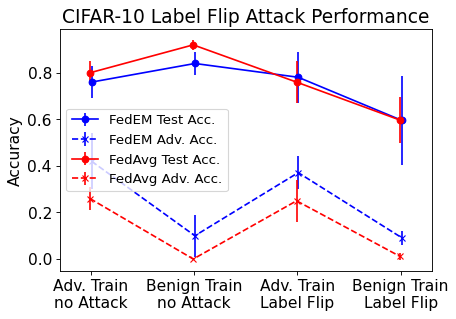

In [39]:
# FedEM
x = [1,2,3,4]

y_fedem_orig_acc = [0.76, 0.84, 0.7808, 0.596]
y_fedem_adv_acc = [0.42, 0.10, 0.371, 0.092]

y_fedavg_orig_acc = [0.80, 0.92, 0.76, 0.597]
y_fedavg_adv_acc = [0.26, 0.00, 0.25, 0.0115]

y_fedem_orig_std = [0.07,0.05, 0.11,0.19]
y_fedem_adv_std = [0.12, 0.09, 0.07, 0.03]

y_fedavg_orig_std = [0.05, 0.02, 0.09, 0.1]
y_fedavg_adv_std = [0.05, 0.00, 0.09, 0.015]


y1 = [y_fedem_orig_acc, y_fedem_adv_acc]
y2 = [y_fedavg_orig_acc, y_fedavg_adv_acc]

std1 = [y_fedem_orig_std, y_fedem_adv_std]
std2 = [y_fedavg_orig_std, y_fedavg_adv_std]

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14}

plt.rc('font', **font)


# Set Labels
labels = ['Adv. Train\nno Attack', 'Benign Train\nno Attack', 'Adv. Train\nLabel Flip', 'Benign Train\nLabel Flip']


names1 = ['FedEM Test Acc.', 'FedEM Adv. Acc.']
names2 = ['FedAvg Test Acc.', 'FedAvg Adv. Acc.']
colors = ['b','r']
types = ['-', '--']
marker_type = ['o','x']

offset = 0.008
fig, ax = plt.subplots(figsize=(6, 4), dpi=80)
for i in range(len(names1)):
    ax.errorbar(np.array(x) + offset,y1[i], std1[i], label= names1[i], linestyle = types[i], color = colors[0], marker = marker_type[i])
for i in range(len(names2)):
    ax.errorbar(np.array(x) - offset,y2[i], std2[i], label= names2[i], linestyle = types[i], color = colors[1], marker = marker_type[i])
    
plt.legend(frameon=True, loc = 'best', prop = {'size':12})
plt.xlim(0.7, 4.3);
# plt.ylim(0, 1.0);
# plt.xlabel('Number of Clients Participating in Learning')
plt.ylabel('Accuracy')
plt.title("CIFAR-10 Label Flip Attack Performance")
ax.set_xticks(x)
# ax.set_xlabel('Plan Method')
ax.set_xticklabels(labels)


In [35]:
np.array(x) + offset[i]

array([0.90, 1.90, 2.90, 3.90])